In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist, cdist
from scipy.spatial import cKDTree, distance_matrix
from scipy.stats import mode
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from itertools import combinations
import pandas as pd
from IPython.display import HTML, display

data_blobs = pd.read_csv("../data/blobs.csv")
data_cancer = pd.read_csv("../data/cancer.csv")
#print(data_cancer)

# 0. Dunn index

$ D = \frac { \min _ { i \neq j } \rho \left( \mu _ { i } , \mu _ { j } \right) } { \max _ { x _ { i } , x _ { j } \in \mu } \rho \left( x _ { i } , x _ { j } \right) }$

In [2]:
def dunn(vectors, clusters):  
    clustered_vectors = defaultdict(list)
    for key, val in zip(clusters, vectors):
        clustered_vectors[key].append(list(val))
    clustered_vectors = list(clustered_vectors.values())

    try: 
        max_diameter = np.max([np.max(pdist(v)) for v in clustered_vectors])
        min_distance = np.min([np.min(cdist(a, b)) for (a, b) in combinations(clustered_vectors, 2)])
    except ValueError:
        return np.nan
    
    return min_distance / max_diameter

# 1. K-means

In [3]:
def k_means(vectors, k = 2):
    """ k-means algorithm. Return centers of clusters """
    
    clusters = np.empty_like(vectors.shape[0])
    
    # Randomly generate k points
    centers = np.random.uniform(np.min(vectors[:,0]), np.max(vectors[:,1]), size=(k, vectors.shape[1]))
    rep_vectors = np.repeat([vectors], k, axis=0)
    while True:
        old_centers = centers.copy()
        
        _centers = np.reshape(np.repeat([centers], vectors.shape[0], axis = 1), (k, vectors.shape[0], vectors.shape[1]))
        cost = np.sum(np.min(np.array([np.linalg.norm(x, axis=1) for x in rep_vectors - _centers]), axis=1))
        
        # Computing distances from every point in dataset to centers
        distances = np.array([centers - vector for vector in vectors])
        distances = np.array([np.linalg.norm(array, axis=1) for array in distances])
        
        # Assigning clusters to vectors
        clusters = np.argmin(distances, axis=1)
        
        clustered_vectors = defaultdict(list)
        for key, val in zip(clusters, vectors):
            clustered_vectors[key].append(list(val))
        
        # Moving centers
        centers = np.array([np.sum(v, axis=0)/len(v) for (k, v) in clustered_vectors.items()])
        
        # Dealing with empty clusters
        if centers.shape[0] < old_centers.shape[0]:
            new_random_vecs = np.random.uniform(np.min(vectors[:,0]), np.max(vectors[:,0]), size=(old_centers.shape[0] - centers.shape[0], vectors.shape[1]))
            centers = np.vstack([centers, new_random_vecs])
        
        _centers = np.reshape(np.repeat([centers], vectors.shape[0], axis = 1), (k, vectors.shape[0], vectors.shape[1]))
        new_cost = np.sum(np.min(np.array([np.linalg.norm(x, axis=1) for x in rep_vectors - _centers]), axis=1))
        
        if abs(new_cost - cost) < 0.01:
            break
        
    return (centers, clusters)

k,Dunn index
2,0.030927
3,0.006026
4,0.019703
5,0.023133


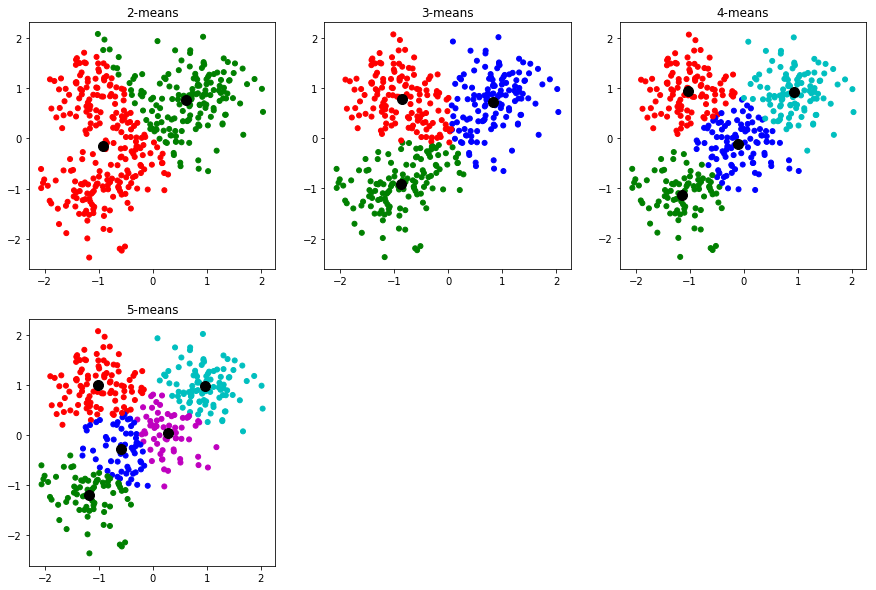

In [4]:
dl = []
colors = np.array(['r', 'g', 'b', 'c', 'm', 'y', 'k'])

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
vectors = data_blobs.values

for k in range(2, 6):
    ax = fig.add_subplot(2, 3, k-1)
    centers, clusters = k_means(vectors, k = k)

    ax.plot(centers[:,0], centers[:,1], 'ko', ms = 10)
    ax.scatter(data_blobs.X, data_blobs.Y, s=25, c=[colors[c] for c in clusters])
    ax.set_title('{}-means'.format(k))
    dl.append(dunn(vectors, clusters))

df = pd.DataFrame({'k': list(range(2, 6)), 'Dunn index': dl})
display(HTML(df.to_html(index=False)))

# 2. DBSCAN

In [5]:
def dbscan(vectors, eps = 1, m = 5):
    #vectors = np.transpose([x, y])
    kd = cKDTree(vectors)
    
    current_cluster = 0
    
    # -1 - not seen
    #  0 - noise
    # >0 - cluster
    
    labels = np.full(vectors.shape[0], -1, dtype=np.int8)
    
    for idx in range(0, vectors.shape[0]):
        if (labels[idx] != -1):
            continue
        neighbours = kd.query_ball_point(vectors[idx], eps)
        
        if (len(neighbours) - 1 < m):
            labels[idx] = 0
            continue
            
        current_cluster += 1
        labels[idx] = current_cluster
        
        # TODO: убрать то, что мы много раз итерируем по одним и тем же точкам
        for neighbour_idx in neighbours:
            if (labels[neighbour_idx] == 0):
                labels[neighbour_idx] = current_cluster
            if (labels[neighbour_idx] != -1):
                continue
            labels[neighbour_idx] = current_cluster
            sec_neighbours = kd.query_ball_point(vectors[neighbour_idx], eps)
            if (len(sec_neighbours) - 1 >= m):
                neighbours += sec_neighbours
                    
    return labels

Dunn index 0.05219684440211838


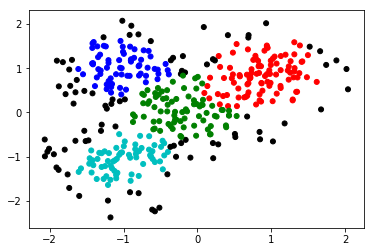

In [6]:
labels = dbscan(vectors, eps=0.48, m=40)
colors = np.array(['k', 'r', 'g', 'b', 'c'] * 30)
plt.scatter(data_blobs.X, data_blobs.Y, s=25, c=[colors[c] for c in labels])

denoised_data = np.array([[i, j, k] for (i,j,k) in zip(data_blobs.X, data_blobs.Y, labels) if k != 0])
print('Dunn index', dunn(denoised_data[:,0:2], denoised_data[:,2]))

# 3. Agglomerative Clustering 

In [7]:
def agg_clust(vectors, k = 2):

    distances = distance_matrix(vectors, vectors)
    clusters = [[i] for i in range(0, vectors.shape[0])]
    
    while len(clusters) > k:
        i, j = np.unravel_index(np.argmin(np.ma.masked_where(distances==0, distances)), distances.shape)

        if i > j:
            i, j = j, i

        new_distances = np.copy(distances)
        new_distances = np.delete(new_distances, j, axis=1)
        new_distances = np.delete(new_distances, j, axis=0)
        new_distances[i, :] = np.max(np.delete(distances[:,[i, j]], j, axis=0), axis = 1)
        new_distances[i,i] = 0
        new_distances[:, i] = new_distances[i]
        distances = new_distances

        clusters[i] += clusters[j]
        del clusters[j]
        
    
    labels = np.empty(vectors.shape[0], dtype=np.int8)
    for (idx, cluster) in enumerate(clusters):
        labels[cluster] = idx
    
    return labels

k,Dunn index
2,0.029387
3,0.035664
4,0.047004
5,0.046179


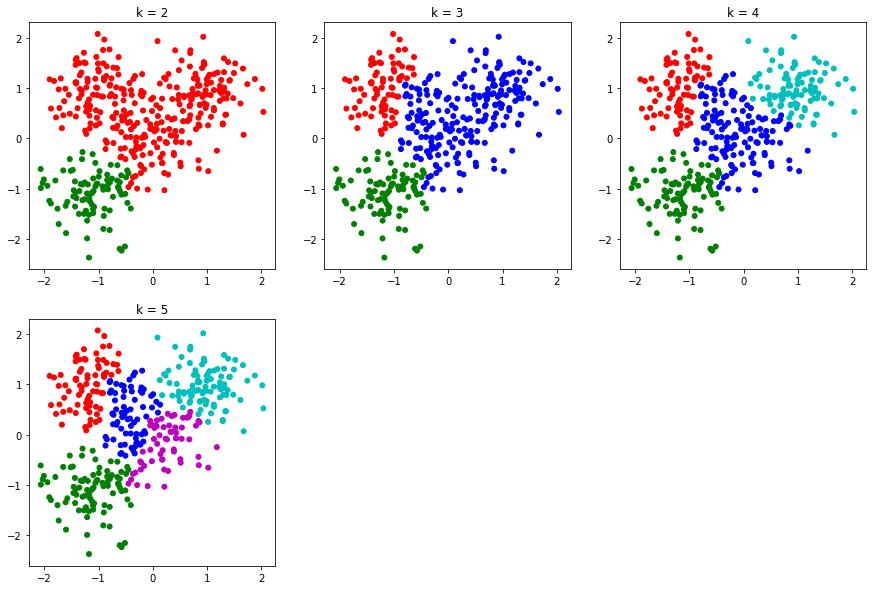

In [8]:
dl = []
colors = np.array(['r', 'g', 'b', 'c', 'm', 'y', 'k'])

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

vectors = data_blobs.values

for k in range(2, 6):
    ax = fig.add_subplot(2, 3, k-1)
    labels = agg_clust(vectors, k = k)

    ax.scatter(data_blobs.X, data_blobs.Y, s=25, c=[colors[c] for c in labels])
    ax.set_title('k = {}'.format(k))
    dl.append(dunn(vectors, labels))

df = pd.DataFrame({'k': list(range(2, 6)), 'Dunn index': dl})
display(HTML(df.to_html(index=False)))

# 4. Cancer k-means
## Not scaled

In [9]:
def purity(cluster_labels, class_labels):
    clusters = np.unique(cluster_labels)
    return np.sum([mode(class_labels[cluster_labels == cluster])[1].item() for cluster in clusters])/class_labels.size

In [10]:
pur = []

vectors = data_cancer.drop("label", axis=1).values
class_labels = data_cancer["label"].values

for k in range(2, 11):
    _, cluster_labels = k_means(vectors, k = k)

    pur.append(purity(cluster_labels, class_labels))

df = pd.DataFrame({'k': list(range(2, 11)), 'Purity': pur})
display(HTML(df.to_html(index=False)))

/home/ilia/.pyenv/versions/3.7.2/envs/datasci/lib/python3.7/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


k,Purity
2,0.854130
3,0.887522
4,0.834798
5,0.891037
6,0.876977
7,0.891037
8,0.891037
9,0.908612
10,0.891037


## Scaled

In [11]:
pur = []

vectors = MinMaxScaler().fit_transform(vectors)
class_labels = data_cancer["label"].values

for k in range(2, 11):
    _, cluster_labels = k_means(vectors, k = k)

    pur.append(purity(cluster_labels, class_labels))

df = pd.DataFrame({'k': list(range(2, 11)), 'Purity': pur})
display(HTML(df.to_html(index=False)))

/home/ilia/.pyenv/versions/3.7.2/envs/datasci/lib/python3.7/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


k,Purity
2,0.915641
3,0.936731
4,0.903339
5,0.922671
6,0.920914
7,0.924429
8,0.931459
9,0.910369
10,0.891037
